In [1]:
### In this notebook I ll be experimenting with different weights for ensembling the model.

In [1]:
import numpy as np
import pandas as pd 
import os
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset,DataLoader
import torchvision 
from torchvision import transforms, models
from tqdm.notebook import tqdm
from PIL import Image
import seaborn as sns
from collections import OrderedDict

In [2]:
from glob import glob
import torch.nn.functional as F
from torch import nn, optim

In [3]:
import warnings
warnings.filterwarnings('ignore')

### Data Locations

In [4]:
data_dir = {
    "train" : "/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/Chest XR covid/train/",
    "valid": "/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/Chest XR covid/validation/",
    "test" : "/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/Chest XR covid/test/"
}
label_csv = {"train": '/media/brats/DRIVE1/akansh/DeepXrays/Data/processed/train_labels.csv',
            "valid": "/media/brats/DRIVE1/akansh/DeepXrays/Data/processed/validation_labels.csv",
            "test": "/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/submission.csv"}

### Dataset

In [5]:
### Dataloader
class covid_dataset(Dataset):
    def __init__(self, image_loc, label_loc, transform, data_type = 'train'):
        filenames = []
        for root, dirs, files in os.walk(image_loc):
            for file in files:
                if file.endswith('.jpg') == True or file.endswith('.png') == True :
                    filenames.append(file)
#         print(len(filenames))
        if data_type == 'train' or data_type == 'valid':
            self.full_filenames = glob(image_loc+'*/*.*')
        else:
            self.full_filenames = glob(image_loc+'*.*')
#         print(len(self.full_filenames))
            
            
        label_df = pd.read_csv(label_loc)
        label_df.set_index("case", inplace = True)
        self.labels = [label_df.loc[filename].values[0] for filename in filenames]
        
        self.transform = transform
        
    def __len__(self):
        return len(self.full_filenames)
    
    def __getitem__(self,idx):
        image = Image.open(self.full_filenames[idx])
        image = image.convert('RGB')        
        image = self.transform(image)
        return image, self.labels[idx]

In [6]:
data_transforms = {
    
    'train': transforms.Compose([
#         transforms.Resize((256,256)),
#         transforms.CenterCrop((224,224)),
#         transforms.RandomVerticalFlip(p =.5),
#         transforms.RandomHorizontalFlip(p = 0.5),
#         transforms.ColorJitter((0.85,1.05)),
#         transforms.RandomRotation((-30,30)),
        transforms.ToTensor(),
#         transforms.Normalize([0.5027,0.5027,0.5027],[0.2466, 0.2466, 0.2466])
        
    ]),
    
    'valid' : transforms.Compose([
#         transforms.Resize((224,224)),
        transforms.ToTensor(),
#         transforms.Normalize([0.5027,0.5027,0.5027],[0.2466, 0.2466, 0.2466])
    ])
    
    
}

valid_data = covid_dataset(image_loc = data_dir['valid'],
                          label_loc = label_csv['valid'],
                          transform = data_transforms['valid'],
                          data_type = 'valid')

train_data = covid_dataset(image_loc = data_dir['train'],
                          label_loc = label_csv['train'],
                          transform = data_transforms['train'],
                          data_type = 'train')

trainloader = DataLoader(train_data,batch_size = 64,shuffle = True)
validloader = DataLoader(valid_data,batch_size = 32,shuffle = False)

### Loading the Numpy array of different model

In [12]:
from torch.nn import functional as F
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, f1_score 

In [8]:
def ensemble_model(array_list, weights, true_labels,en_type = 'val' ):
    ensemble = np.sum(np.array(array_list)*np.array(weights).reshape(len(weights),1,1), axis = 0)
    y_pred_ensemble  = F.softmax(torch.from_numpy(ensemble), dim = 1).numpy()
    y_pred_ensemble = np.argmax(y_pred_ensemble, axis=1)
    print(np.unique(y_pred_ensemble, return_counts=True))
    
    if en_type == 'val':
        print(f"Accuracy Score: {accuracy_score(true_labels,y_pred_ensemble)*100}")
        print(f"F1 score: {f1_score(true_labels, y_pred_ensemble, average = 'macro')*100}")
    
        cm = confusion_matrix(true_labels,y_pred_ensemble, labels = [0,1,2])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels = [0,1,2])
    
        disp.plot()
        plt.show()
    elif en_type == 'test':
        test_csv = pd.read_csv("/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/submission.csv")
        test_csv[' class'] = y_pred_ensemble
        name = input("Enter the name")
        test_csv.to_csv(str(name)+'.csv', index = False)
    else:
        pass

In [9]:
denseNet_train = np.load("./Train_probab/denseNet_train.npy")
denseNet_train_bl = np.load("./Train_probab/denseNet_train_Bl.npy")
efficientNet_1422_train = np.load('Train_probab/efficientNet_1422_Train.npy')
efficient_Net_best_loss_train = np.load('Train_probab/efficientNet_best_loss_Train.npy')
efficientNet_orig_train = np.load('Train_probab/effNet-kaggleModelTrain.npy')
# efficientNet_96_25_train = np.load('Train_probab/efficientNet_96.25_Train.npy')
# train = [denseNet_train,
#      denseNet_train_bl,
#      efficientNet_1422_train,
#      efficient_Net_best_loss_train,
#      efficientNet_orig_train,
#         efficientNet_96_25_train]
train = [denseNet_train,
     denseNet_train_bl,
     efficientNet_1422_train,
     efficient_Net_best_loss_train,
     efficientNet_orig_train]

In [10]:
denseNet_valid = np.load("./Validation_probab/denseNet_valid.npy")
denseNet_valid_bl = np.load("./Validation_probab/denseNet_valid_Bl.npy")
efficientNet_1422_valid = np.load('Validation_probab/efficientNet_1422_Valid.npy')
efficient_Net_best_loss_valid = np.load('Validation_probab/efficientNet_best_loss_Valid.npy')
efficientNet_orig_valid = np.load('Validation_probab/effNet-kaggleModelValid.npy')
efficientNet_96_25 = np.load('./Validation_probab/efficientNet_96.25_Valid.npy')
# valid = [denseNet_valid,
#      denseNet_valid_bl,
#      efficientNet_1422_valid,
#      efficient_Net_best_loss_valid,
#      efficientNet_orig_valid,
#     efficientNet_96_25]
valid = [denseNet_valid,
     denseNet_valid_bl,
     efficientNet_1422_valid,
     efficient_Net_best_loss_valid,
     efficientNet_orig_valid,]

In [11]:
denseNet_test = np.load("./Test_probab/denseNet_test.npy")
denseNet_test_bl = np.load("./Test_probab/denseNet_test_Bl.npy")
efficientNet_1422_test = np.load('Test_probab/efficientNet_1422_Test.npy')
efficient_Net_best_loss_test = np.load('Test_probab/efficientNet_best_loss_Test.npy')
efficientNet_orig_test = np.load('Test_probab/effNet-kaggleModelTest.npy')
efficientNet_96_25 = np.load('./Test_probab/efficientNet_96.25_Test.npy')
test = [denseNet_test,
     denseNet_test_bl,
     efficientNet_1422_test,
     efficient_Net_best_loss_test,
     efficientNet_orig_test,
    efficientNet_96_25]

(array([0, 1, 2]), array([1415, 1049,  968]))
Accuracy Score: 95.65850815850816


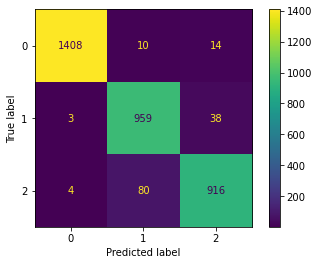

(array([0, 1, 2]), array([1406, 1039,  987]))
Accuracy Score: 95.22144522144522


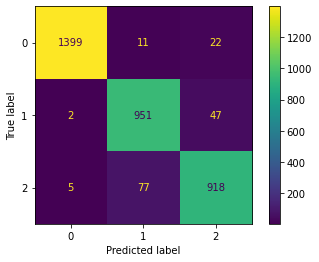

(array([0, 1, 2]), array([1448,  975, 1009]))
Accuracy Score: 95.54195804195804


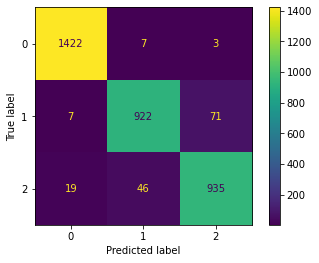

(array([0, 1, 2]), array([1414, 1016, 1002]))
Accuracy Score: 95.97902097902097


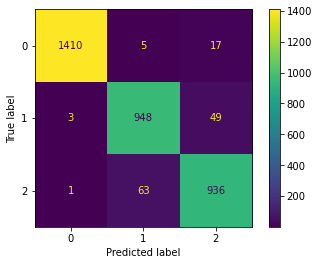

(array([0, 1, 2]), array([1419,  996, 1017]))
Accuracy Score: 95.6002331002331


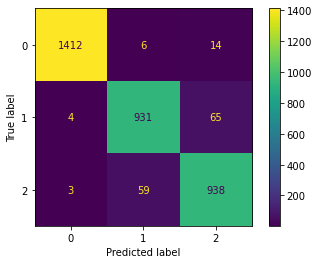

(array([0, 1, 2]), array([1425, 1039,  968]))
Accuracy Score: 96.5034965034965


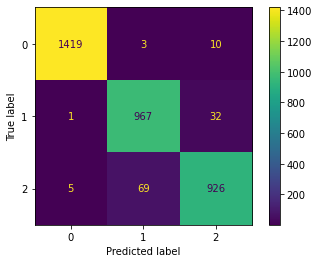

In [18]:
ensemble_model(denseNet_valid, [1], valid_data.labels ) #Accuracy Score: 95.65850815850816 
ensemble_model(denseNet_valid_bl, [1], valid_data.labels) #Accuracy Score: 95.22144522144522
ensemble_model(efficientNet_1422_valid, [1], valid_data.labels) #Accuracy Score: 95.54195804195804
ensemble_model(efficient_Net_best_loss_valid, [1], valid_data.labels) #Accuracy Score: 95.97902097902097
ensemble_model(efficientNet_orig_valid, [1], valid_data.labels) #Accuracy Score: 95.6002331002331
ensemble_model(efficientNet_96_25, [1], valid_data.labels)

(array([0, 1, 2]), array([1417, 1017,  998]))
Accuracy Score: 96.0081585081585
F1 score: 95.54340433533956


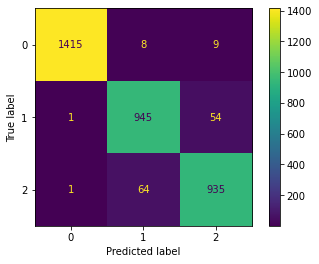

In [13]:
#Average
A = [denseNet_valid,denseNet_valid_bl,efficientNet_1422_valid,efficient_Net_best_loss_valid,efficientNet_orig_valid]
ensemble_model(A, len(A)*[1], valid_data.labels)
# ensemble_model(B, [1,1,1,1,1], None, en_type=None)

(array([0, 1, 2]), array([6531, 7172, 4255]))
Accuracy Score: 98.5410402049226
F1 score: 98.37365236722074


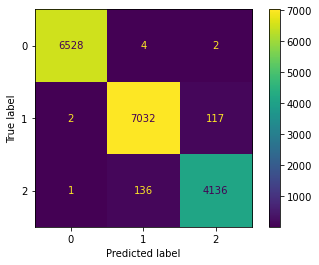

In [14]:
ensemble_model(train, len(train)*[1], train_data.labels)

(array([0, 1, 2]), array([1426, 1011,  995]))
Accuracy Score: 96.35780885780886
F1 score: 95.93881776842017


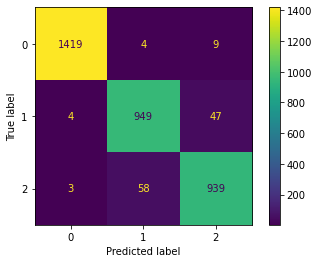

(array([0, 1, 2]), array([6522, 7099, 4337]))
Accuracy Score: 98.29602405613097
F1 score: 98.11935180041208


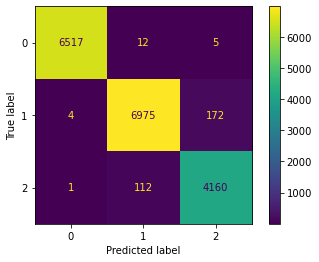

In [17]:
#Old
ensemble_model(valid, [0,0,.4,.5,.1], valid_data.labels) #Maybe??
ensemble_model(train, [0,0,.4,.5,.1], train_data.labels) #Yes it worked giving best score probab

(array([0, 1, 2]), array([1420, 1020,  992]))
Accuracy Score: 96.12470862470862


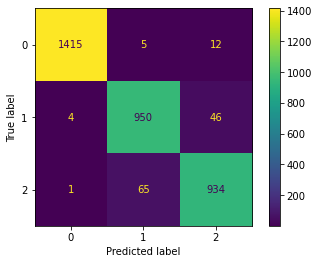

(array([0, 1, 2]), array([399, 417, 384]))


In [13]:
ensemble_model(valid, [0,0,.3,.6,0.0,0], valid_data.labels)
ensemble_model(test, [0,0,.3,.6,0.0,0], None, None) #Yes it worked giving best score probab

In [106]:
ensemble_model(test, [0,0,0.1,0.1,.8,0], None, 'test')

(array([0, 1, 2]), array([400, 406, 394]))
Enter the namedelete


In [108]:
#Jugad
from PIL import Image
import matplotlib.pyplot as plt

label = pd.read_csv("./delete.csv")

covid_img = []
for i in os.listdir("/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/Chest XR covid/test/"):
    if plt.imread("/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/Chest XR covid/test/"+i).shape[0] == 512:
        covid_img.append(i)




for i in covid_img:
    if label[label['case'] == i][' class'].values[0] != 0:
        print(i)

0356.jpg
0574.jpg
0752.jpg
0967.jpg


### Weight search

In [21]:
def find_ensemble_model_weights(array_list, weights, true_labels):
    ensemble = np.sum(np.array(array_list)*np.array(weights).reshape(len(weights),1,1), axis = 0)
    y_pred_ensemble  = F.softmax(torch.from_numpy(ensemble), dim = 1).numpy()
    y_pred_ensemble = np.argmax(y_pred_ensemble, axis=1)
    
    return accuracy_score(true_labels,y_pred_ensemble)*100

In [62]:
weights = np.arange(0,1.05,0.05)
Accuracy_score = 0
W = []
[w1,w2,w3,w4,w5, w6] = [0,0,0,0,0,0]

# for w1 in tqdm(weights):
#     for w2 in (weights):
for w3 in tqdm(weights):
    for w4 in (weights):
        for w5 in weights:
            for w6 in weights:
                if w1+w2+w3+w4+w5+w6 == 1:
                    acc_train = find_ensemble_model_weights(train, [w1,w2,w3,w4,w5,w6], train_data.labels)
                    acc_val = find_ensemble_model_weights(valid, [w1,w2,w3,w4,w5,w6], valid_data.labels)
                    if acc_train >= Accuracy_score:
                        Accuracy_score = acc
                        print("train:", Accuracy_score)
                        print("val: ", acc_val)
                        W = [w1,w2,w3,w4,w5,w6]
                        print(W)

            

  0%|          | 0/21 [00:00<?, ?it/s]

train: 99.23154026060809
val:  96.5034965034965
[0, 0, 0.0, 0.0, 0.0, 1.0]
train: 99.23154026060809
val:  96.67832167832168
[0, 0, 0.0, 0.0, 0.35000000000000003, 0.65]
train: 99.23154026060809
val:  96.76573426573427
[0, 0, 0.0, 0.0, 0.4, 0.6000000000000001]
train: 99.23154026060809
val:  96.7948717948718
[0, 0, 0.0, 0.0, 0.45, 0.55]
train: 99.23154026060809
val:  96.5909090909091
[0, 0, 0.0, 0.05, 0.25, 0.7000000000000001]
train: 99.23154026060809
val:  96.5909090909091
[0, 0, 0.0, 0.05, 0.30000000000000004, 0.65]
train: 99.23154026060809
val:  96.64918414918415
[0, 0, 0.0, 0.05, 0.35000000000000003, 0.6000000000000001]
train: 99.23154026060809
val:  96.70745920745921
[0, 0, 0.0, 0.05, 0.4, 0.55]
train: 99.23154026060809
val:  96.53263403263404
[0, 0, 0.0, 0.1, 0.2, 0.7000000000000001]
train: 99.23154026060809
val:  96.53263403263404
[0, 0, 0.0, 0.1, 0.25, 0.65]
train: 99.23154026060809
val:  96.62004662004662
[0, 0, 0.0, 0.1, 0.30000000000000004, 0.6000000000000001]
train: 99.2315402

train: 99.23154026060809
val:  96.62004662004662
[0, 0, 0.1, 0.25, 0.05, 0.6000000000000001]
train: 99.23154026060809
val:  96.64918414918415
[0, 0, 0.1, 0.25, 0.1, 0.55]
train: 99.23154026060809
val:  96.73659673659674
[0, 0, 0.1, 0.25, 0.15000000000000002, 0.5]
train: 99.23154026060809
val:  96.62004662004662
[0, 0, 0.1, 0.30000000000000004, 0.0, 0.6000000000000001]
train: 99.23154026060809
val:  96.64918414918415
[0, 0, 0.1, 0.30000000000000004, 0.05, 0.55]
train: 99.23154026060809
val:  96.67832167832168
[0, 0, 0.1, 0.35000000000000003, 0.0, 0.55]
train: 99.23154026060809
val:  96.67832167832168
[0, 0, 0.1, 0.35000000000000003, 0.05, 0.5]
train: 99.23154026060809
val:  96.5909090909091
[0, 0, 0.15000000000000002, 0.0, 0.1, 0.75]
train: 99.23154026060809
val:  96.53263403263404
[0, 0, 0.15000000000000002, 0.0, 0.15000000000000002, 0.7000000000000001]
train: 99.23154026060809
val:  96.62004662004662
[0, 0, 0.15000000000000002, 0.0, 0.2, 0.65]
train: 99.23154026060809
val:  96.5326340

train: 99.23154026060809
val:  96.73659673659674
[0, 0, 0.25, 0.2, 0.0, 0.55]
train: 99.23154026060809
val:  96.70745920745921
[0, 0, 0.25, 0.2, 0.05, 0.5]
train: 99.23154026060809
val:  96.64918414918415
[0, 0, 0.25, 0.2, 0.1, 0.45]
train: 99.23154026060809
val:  96.67832167832168
[0, 0, 0.25, 0.25, 0.0, 0.5]
train: 99.23154026060809
val:  96.62004662004662
[0, 0, 0.25, 0.25, 0.05, 0.45]
train: 99.23154026060809
val:  96.64918414918415
[0, 0, 0.30000000000000004, 0.0, 0.0, 0.7000000000000001]
train: 99.23154026060809
val:  96.73659673659674
[0, 0, 0.30000000000000004, 0.0, 0.05, 0.65]
train: 99.23154026060809
val:  96.5909090909091
[0, 0, 0.30000000000000004, 0.0, 0.1, 0.6000000000000001]
train: 99.23154026060809
val:  96.76573426573427
[0, 0, 0.30000000000000004, 0.0, 0.15000000000000002, 0.55]
train: 99.23154026060809
val:  96.82400932400932
[0, 0, 0.30000000000000004, 0.0, 0.2, 0.5]
train: 99.23154026060809
val:  96.67832167832168
[0, 0, 0.30000000000000004, 0.0, 0.25, 0.45]
train:

(array([0, 1, 2]), array([1434, 1011,  987]))
Accuracy Score: 96.64918414918415


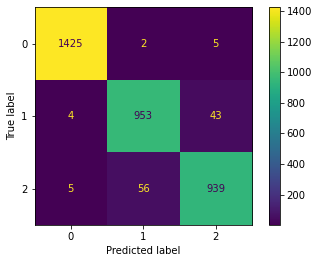

(array([0, 1, 2]), array([402, 424, 374]))


In [64]:
ensemble_model(valid, W, valid_data.labels) #
ensemble_model(test, W, None, en_type=None) 

In [49]:
1+20+21

42

(array([0, 1, 2]), array([1427, 1032,  973]))
Accuracy Score: 96.91142191142191


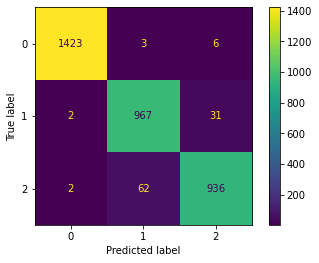

(array([0, 1, 2]), array([401, 427, 372]))


In [46]:
W = [0, 0, 0.15000000000000002, 0.0, 0.0, 0.5]
ensemble_model(A, W, valid_data.labels) #
ensemble_model(B, W, None, en_type=None)

### SVM based classifier

In [14]:
import pandas as pd

In [15]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import svm, ensemble
import matplotlib.pyplot as plt
import numpy as np

In [16]:
from sklearn import metrics

In [17]:
from sklearn.preprocessing import StandardScaler

In [18]:
from sklearn.utils import shuffle

In [20]:
# ensemble_train = pd.concat([pd.DataFrame(C[0]),pd.DataFrame(C[1]),pd.DataFrame(C[2]),pd.DataFrame(C[3]),pd.DataFrame(C[4]),pd.DataFrame(train_data.labels)], axis=1, ignore_index=True)

ensemble_train = pd.concat([pd.DataFrame(train[2]),pd.DataFrame(train[3]),pd.DataFrame(train[4]),pd.DataFrame(train[5]),pd.DataFrame(train_data.labels)], axis=1, ignore_index=True)

In [21]:
ensemble_train = shuffle(ensemble_train, random_state= 49)

In [22]:
ensemble_train.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12
2456,1.000000,9.543369e-10,2.829389e-10,9.999983e-01,1.119079e-06,5.939984e-07,0.999949,2.436494e-05,2.648556e-05,1.000000,5.574708e-09,4.300465e-11,0
14305,0.014844,4.327028e-03,9.808286e-01,6.338168e-07,2.082625e-05,9.999785e-01,0.000206,2.864461e-03,9.969293e-01,0.000010,1.150285e-04,9.998747e-01,2
7737,0.000064,9.990911e-01,8.452102e-04,7.155446e-06,9.978265e-01,2.166283e-03,0.000160,9.970812e-01,2.758316e-03,0.006914,9.928833e-01,2.029546e-04,1
3721,1.000000,2.094083e-09,1.394429e-07,9.999996e-01,2.017405e-08,3.194834e-07,1.000000,1.922444e-14,7.262505e-12,1.000000,4.245791e-27,6.503412e-28,0
15151,0.000887,2.989691e-01,7.001442e-01,3.581026e-02,3.280129e-01,6.361769e-01,0.010597,6.733640e-01,3.160390e-01,0.000342,6.503152e-01,3.493431e-01,2


In [23]:
scaler = StandardScaler()

#train
scaler.fit(ensemble_train.iloc[:,:-1])
X_train = pd.DataFrame(scaler.fit_transform(ensemble_train.iloc[:,:-1]))
y_train = ensemble_train.iloc[:,-1]

#valid
ensemble_valid = pd.concat([pd.DataFrame(valid[2]),pd.DataFrame(valid[3]),pd.DataFrame(valid[4]),pd.DataFrame(valid[5]),pd.DataFrame(valid_data.labels)], axis=1, ignore_index=True)
X_valid = pd.DataFrame(scaler.transform(ensemble_valid.iloc[:,:-1]))
y_valid = ensemble_valid.iloc[:,-1]

#test
ensemble_test = pd.concat([pd.DataFrame(test[2]),pd.DataFrame(test[3]),pd.DataFrame(test[4]),pd.DataFrame(test[5])], axis=1, ignore_index=True)
X_real_test = pd.DataFrame(scaler.transform(ensemble_test))


In [24]:
model = svm.SVC()
model.fit(X_train,y_train)
print(metrics.accuracy_score(y_train, model.predict(X_train)))
print(metrics.accuracy_score(y_valid, model.predict(X_valid)))


0.9937632253034859
0.9662004662004662


In [25]:
model = svm.SVC(kernel='linear', C=1, decision_function_shape='ovo').fit(X_train, y_train)
print('Linear')
print(metrics.accuracy_score(y_train, model.predict(X_train)))
print(metrics.accuracy_score(y_valid, model.predict(X_valid)))
print(np.unique(model.predict(X_real_test), return_counts=True))
model = svm.SVC(kernel='rbf', gamma='scale', C=10, decision_function_shape='ovo').fit(X_train, y_train)
print('RBF')
print(metrics.accuracy_score(y_train, model.predict(X_train)))
print(metrics.accuracy_score(y_valid, model.predict(X_valid)))
print(np.unique(model.predict(X_real_test), return_counts=True))

model = svm.SVC(kernel='poly', degree=3, C=1, decision_function_shape='ovo').fit(X_train, y_train)
print('Poly')
print(metrics.accuracy_score(y_train, model.predict(X_train)))
print(metrics.accuracy_score(y_valid, model.predict(X_valid)))
print(np.unique(model.predict(X_real_test), return_counts=True))

model = svm.SVC(kernel='sigmoid', C=1, decision_function_shape='ovo').fit(X_train, y_train)
print('SIGmoid')
print(metrics.accuracy_score(y_train, model.predict(X_train)))
print(metrics.accuracy_score(y_valid, model.predict(X_valid)))
print(np.unique(model.predict(X_real_test), return_counts=True))



Linear
0.9934291123733155
0.9673659673659674
(array([0, 1, 2]), array([403, 427, 370]))
RBF
0.9942087092103797
0.9662004662004662
(array([0, 1, 2]), array([403, 428, 369]))
Poly
0.9932063704198686
0.9670745920745921
(array([0, 1, 2]), array([402, 430, 368]))
SIGmoid
0.9920369751642721
0.9664918414918415
(array([0, 1, 2]), array([402, 414, 384]))


In [26]:
y_pred_ensemble = model.predict(X_real_test)

In [27]:
test_csv = pd.read_csv("/media/brats/DRIVE1/akansh/DeepXrays/Data/raw/submission.csv")
test_csv[' class'] = y_pred_ensemble

In [28]:
test_csv.to_csv('SVM_sigmoind_three.csv', index = False)